## **Support Vector Machine (SVM)**

In [58]:
# Importing all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [26]:
# Loading the dataset
df = pd.read_csv('winequality-red.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [30]:
# Convert to binary classification: quality >= 7 is "good" (1), else "bad" (-1)
y_binary = np.where(y >= 7, 1, -1)
print(y_binary)

[-1 -1 -1 ... -1 -1 -1]


In [27]:
X = df.iloc[:, :-1].values # All columns except the last (features)
y = df.iloc[:, -1].values # Last column (quality score)



In [28]:
print(X)

[[ 7.4    0.7    0.    ...  3.51   0.56   9.4  ]
 [ 7.8    0.88   0.    ...  3.2    0.68   9.8  ]
 [ 7.8    0.76   0.04  ...  3.26   0.65   9.8  ]
 ...
 [ 6.3    0.51   0.13  ...  3.42   0.75  11.   ]
 [ 5.9    0.645  0.12  ...  3.57   0.71  10.2  ]
 [ 6.     0.31   0.47  ...  3.39   0.66  11.   ]]


In [29]:
print(y)

[5 5 5 ... 6 5 6]


In [47]:
# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42, stratify=y_binary)

In [48]:
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**PCA for Dimensionality Reduction**

It is a technique which tranforms high-dimensional data into a lower-dimensional space.

PCA reduces 11-dimensional feature to space to 2D by projecting onto two principal components with the highest variance.



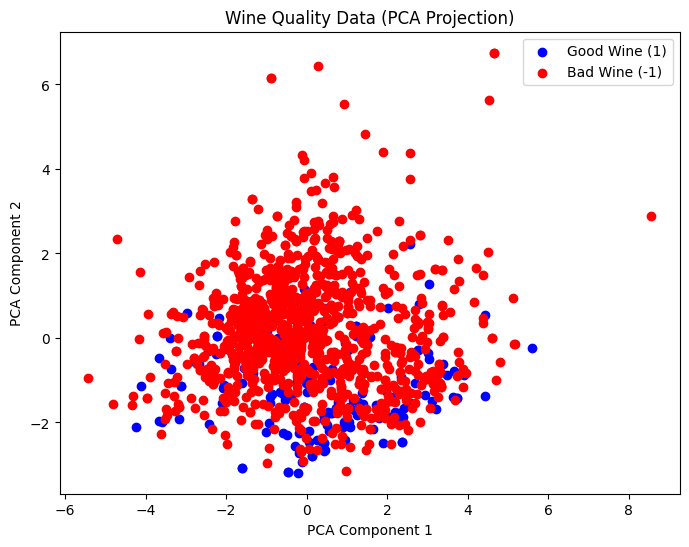

In [50]:
# Reduce to 2D for visualization
pca = PCA(n_components=2)  # reduces the data to 2 features
X_train_pca = pca.fit_transform(X_train) # fits PCA on the training data
X_test_pca = pca.transform(X_test) # Projects the test data (X_test) onto the same 2 components learned from X_train.

# Plotting PCA-transformed traing data to visualize class separation
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[y_train == 1, 0], X_train_pca[y_train == 1, 1], color='b', label='Good Wine (1)')
plt.scatter(X_train_pca[y_train == -1, 0], X_train_pca[y_train == -1, 1], color='r', label='Bad Wine (-1)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Wine Quality Data (PCA Projection)')
plt.legend()
plt.show()

Observation:

The plot shows if good and bad wines form distinct groups in this 2D space, which hints at whether SVM can separate them.





Kernel: A function used in SVM to compute similarity between data points in a transformed space, enabling linear separation of non-linearly separable data without explicitly computing the transformatio

**Kernel Functions**

1. Linear Kernel: : Computes the dot product between two vectors (or matrices). This is the standard kernel for linear SVMs.

2. RBF (Gaussian) Kernel: Computes the similarity between points using a Gaussian function, allowing SVM to handle non-linear separation.



In [36]:
# Linear kernel: computes the dot product between two vectors
def linear_kernel(x1, x2):  # dot product between x1 and x2
  return np.dot(x1, x2.T)
# RBF (Gaussian) kernel: measures similarity with a Gaussian function
def rbf_kernel(x1, x2, gamma=1.0):  #RBF kernel fo rnon-linear speperation
  if x1.ndim == 1:
    x1 = x1[np.newaxis, :]
  if x2.ndim == 1:
    x2 = x2[np.newaxis, :]
  # computing squared Euclidean distance between all pairs of points x1 and x2
  dists = np.sum((x1[:, np.newaxis, :] - x2[np.newaxis, :, :]) ** 2, axis=2)
  return np.exp(-gamma * dists)

**SVM training with SMO Algorithm**

**Sequential Minimal Optimization (SMO)** algorithm to train an SVM by optimizing Lagrange multipliers (alphas) and bias (b) for the wine quality dataset. It uses a kernel (linear or RBF) to classify good/bad wines.

Inputs:
X: Feature matrix (samples × features)
y: Labels (+1 or -1)
kernel: Kernel function (linear or RBF)
C: Regularization parameter
tol: Tolerance for stopping criterion
max_passes: Max iterations with no alpha changes before stopping



In [37]:
# Sequential Minimal Optimization (SMO)
def svm_optimization(X, y, kernel, C=1.0, tol=1e-3, max_passes=5): # SMo for SVM training
  m, n = X.shape  # Initializing m samples
  alphas = np.zeros(m) # Lagrange multipliers
  b = 0 #bias
  passes = 0 # passes tracks iterations without changes
  K = kernel(X, X)  # Computes kernal matrix using Lienar/RBF krenel
  # Outer loop: Continues until passes exceeds max_passes (i.e., no alpha changes for several iterations).
  while passes < max_passes:
    num_changed_alphas = 0
    for i in range(m): # iterating over all samples
      Ei = np.sum(alphas * y * K[:, i]) + b - y[i] # computes error for sample i
      if (y[i]*Ei < -tol and alphas[i] < C) or (y[i]*Ei > tol and alphas[i] > 0): # Checks KKT conditions for updating alphas[i].
        j = np.random.choice([k for k in range(m) if k != i])
        Ej =np.sum(alphas * y * K[:, j]) + b - y[j]  # compares the error for sample j
        alpha_i_old, alpha_j_old = alphas[i], alphas[j]
        if y[i] != y[j]:   # Sets bounds for alphas[j] when labels differ
          L = max(0, alphas[j] - alphas[i])
          H = min(C, C + alphas[j] - alphas[i])
        else:   # Sets bounds when labels are the same.
          L = max(0, alphas[i] + alphas[j] - C)
          H = min(C, alphas[i] + alphas[j])
        if L == H: # Skips if bounds are equal (no update possible).
          continue
        eta = 2 * K[i, j] - K[i, i] - K[j, j]
        if eta >= 0: # skips if invalid
          continue
        alphas[j] -= y[j] * (Ei - Ej) / eta  # update alpha_j
        alphas[j] = np.clip(alphas[j], L, H) # clip to bounds
        if abs(alphas[j] - alpha_j_old) < 1e-5: # skip if change is small
          continue
        alphas[i] += y[i] * y[j] * (alpha_j_old - alphas[j]) # Update alpha_i
        b1 = b - Ei - y[i] * (alphas[i] - alpha_i_old) * K[i, i] - y[j] * (alphas[j] - alpha_j_old) * K[i, j] # Bias candidiate 1
        b2 = b - Ej - y[i] * (alphas[i] - alpha_i_old) * K[i, j] - y[j] * (alphas[j] - alpha_j_old) * K[j, j] # Bias candidate 2
        if 0 < alphas[i] < C:  # Update b using i if support vector
          b = b1
        elif 0 < alphas[j] < C:  # Use j if support vector
          b = b2
        else:   # Average if neither
          b = (b1 + b2) / 2
        num_changed_alphas += 1
    if num_changed_alphas == 0:
      passes += 1
    else:
      passes = 0
  return alphas, b  # Return optimized alphas and bias

**SVM Class Implementation**

This SVM class encapsulates the SVM model, handling initialization, training, and prediction for classifying wines as good/bad using the wine quality dataset’s 11 features. It uses the SMO optimization from your previous snippet and the linear/RBF kernel.

In [38]:
class SVM:
  # Initializes SVM with a kernel and sofe margin parameter 'C', initially the pearameters are set at NONE
  def __init__(self, kernel=linear_kernel, C=1.0):
    self.kernel = kernel
    self.C = C
    self.alphas = None
    self.b = None
    self.support_vectors = None
    self.support_vector_labels = None

  # Trains the SVM on input data X and labels y
  def fit(self, X, y):
    self.X = X # wine features
    self.y = y # good/bad labels
    self.alphas, self.b = svm_optimization(X, y, self.kernel, self.C)  # runs SMO to optimize alphas ans compute b
    support_vector_indices = np.where(self.alphas > 1e-5)[0] # identifies indicies for support vectors
    self.support_vectors = X[support_vector_indices]  # store support vectr features
    self.support_vector_labels = y[support_vector_indices]  # Stores labels of support vectors.
    self.alphas = self.alphas[support_vector_indices]

  # Computes decision function for input X
  def project(self, X):
    K = self.kernel(self.support_vectors, X)
    return np.dot((self.alphas * self.support_vector_labels), K) + self.b

  # Predicts class labels for X.
  def predict(self, X):
    return np.sign(self.project(X))

**Plotting  SVM Decision Boundary**



In [71]:
# Train SVM on PCA-reduced data
svm_pca = SVM(kernel=linear_kernel, C=1.0)
svm_pca.fit(X_train_pca, y_train)

In [73]:
def plot_decision_boundary(svm, X, y, title):
 x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
 y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
 xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                      np.linspace(y_min, y_max, 200))
 grid = np.c_[xx.ravel(), yy.ravel()]
 Z = svm.predict(grid)
 Z = Z.reshape(xx.shape)
 plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm)
 plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
 if hasattr(svm, 'support_vectors'):
  plt.scatter(svm.support_vectors[:, 0], svm.support_vectors[:, 1],
              s=80, facecolors='none', edgecolors='k', label='Support Vectors')
 plt.xlabel('PCA Component 1')
 plt.ylabel('PCA Component 2')
 plt.title(title)
 plt.legend()
 plt.show()
 print(X.shape)


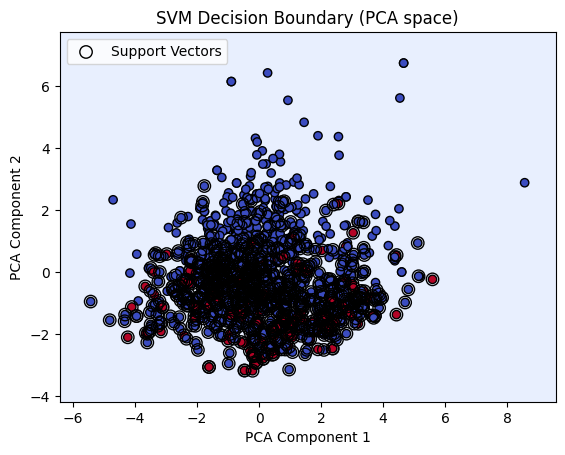

(1279, 2)


In [74]:
plot_decision_boundary(svm_pca, X_train_pca, y_train, "SVM Decision Boundary (PCA space)")

Observation:

The improtant thing to observe here is that in the plot the background is all blue.

This means SVM's decision boundary does not cut through the visible region, that is the data is so unbalanced that the SVM classifies almost everything as one class.

In [51]:
#Train linear SVM on PCA-reduced data
svm_linear = SVM(kernel=linear_kernel, C=1.0)
svm_linear.fit(X_train_pca, y_train)
y_pred_linear = svm_linear.predict(X_test_pca)
acc_linear = np.mean(y_pred_linear == y_test)
print(f"Linear SVM Test Accuracy: {acc_linear:.3f}")

Linear SVM Test Accuracy: 0.866


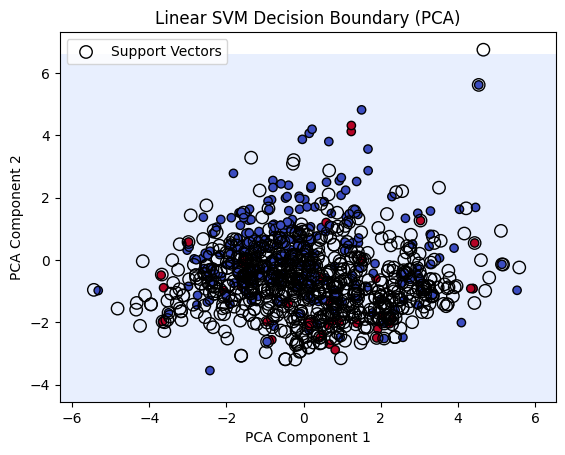

In [52]:
# Visualize decision boundary
plot_decision_boundary(svm_linear, X_test_pca, y_test, "Linear SVM Decision Boundary (PCA)")

Observation:
Each dot is a wine sample, projected onto the first two principal components (PCA).

Color: The color (red/blue) represents the true class label (good/bad wine).

Edge Color: All points have a black edge for visibility

Large Circles:
The larger, unfilled circles are the support vectors—the critical samples that define the SVM’s margin.

Data points of both classes (red and blue) are heavily overlapping in the PCA space. This makes it very difficult for a linear SVM to find a meaningful separating hyperplane.

RBF Kernel SVM Test Accuracy: 0.872


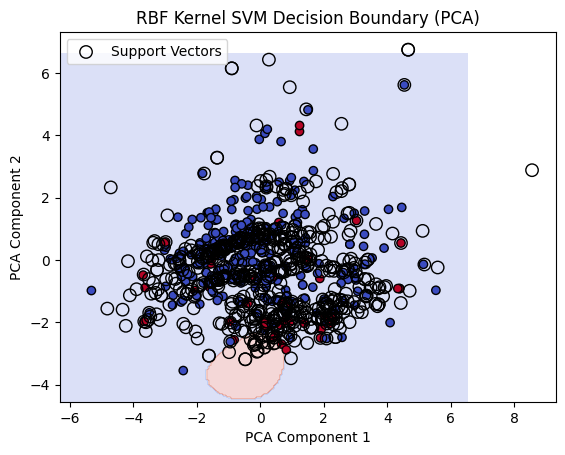

In [53]:
# Train RBF kernel SVM on PCA-reduced data
svm_rbf = SVM(kernel=lambda x1, x2: rbf_kernel(x1, x2, gamma=0.5), C=1.0)
svm_rbf.fit(X_train_pca, y_train)
y_pred_rbf = svm_rbf.predict(X_test_pca)
acc_rbf = np.mean(y_pred_rbf == y_test)
print(f"RBF Kernel SVM Test Accuracy: {acc_rbf:.3f}")
# Visualize decision boundary
plot_decision_boundary(svm_rbf, X_test_pca, y_test, "RBF Kernel SVM Decision Boundary (PCA)")

Oservation:

The RBF (Radial Basis Function) kernel allows the SVM to create a nonlinear decision boundary.

We can see that the colored regions are no longer separated by a straight line, but by curved boundary.

The blue region is where the SVM predicts the majority class.(bad wine)

The blue region is where the SVM predicts the majority class (good wine).

